In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import tensorflow as tf
from pathlib import Path
from time import strftime
from shutil import rmtree
import matplotlib.pyplot as plt

In [2]:
from rtapipe.lib.utils.misc import dotdict
from rtapipe.lib.dataset.dataset import APDataset
from rtapipe.lib.plotting.plotting import plot_sequences
from rtapipe.lib.models.anomaly_detector_builder import AnomalyDetectorBuilder

In [3]:
dataset_config = ! pwd
dataset_config = dataset_config.pop()
dataset_config = Path(dataset_config).joinpath("../lib/dataset/config/agilehost3-prod5.yml")
dataset_config

PosixPath('/data01/homes/baroncelli/phd/rtapipe/notebooks/../lib/dataset/config/agilehost3-prod5.yml')

# Loading the dataset

In [4]:
dataset_id = 1201
tsl=5

In [5]:
ds = APDataset.get_dataset(dataset_config, dataset_id, scaler_type="mm", out_dir="./")
ds.loadData()
train_x, train_y, val_x, val_y = ds.train_val_split(tsl=tsl, stride=1, split=50)
features_names = ["EB_"+fn.split("_")[1]+" TeV" for fn in ds.getFeaturesColsNames()]
print(train_x.shape)
print(val_x.shape)

Loading dataset from /data01/homes/baroncelli/phd/rtapipe/scripts/ml/dataset_generation/single_long_photon_list/training/ap_output/runid_notemplate_trial_0000000002_simtype_bkg_onset_0_delay_0_offset_0.5_itype_te_itime_5_normalized_True.csv
Single csv file shape: (3600, 8)
Dataframe shape: (3600, 8). Columns: ['TMIN' 'TMAX' 'COUNTS_0.04-0.117' 'ERROR_0.04-0.117' 'COUNTS_0.117-0.342'
 'ERROR_0.117-0.342' 'COUNTS_0.342-1.0' 'ERROR_0.342-1.0']
Dropped columns=['ERROR_0.04-0.117', 'ERROR_0.342-1.0', 'TMAX', 'TMIN', 'ERROR_0.117-0.342'] from dataset
Dataframe shape: (3600, 3). Columns: ['COUNTS_0.04-0.117' 'COUNTS_0.117-0.342' 'COUNTS_0.342-1.0']
Training set: (1798, 5, 3) Labels: (1798,)
Validation set: (1798, 5, 3) Labels: (1798,)
(1798, 5, 3)
(1798, 5, 3)


In [6]:
ds.load_test_data("itime_5_b")
test_x, test_y = ds.get_test_set(stride=1)

Test set size: 10
Pivot index:  50
Loaded 10 files. Single file shape: (96, 5, 3)
text_x shape: (960, 5, 3)
text_y shape: (960,)


## Plot some samples

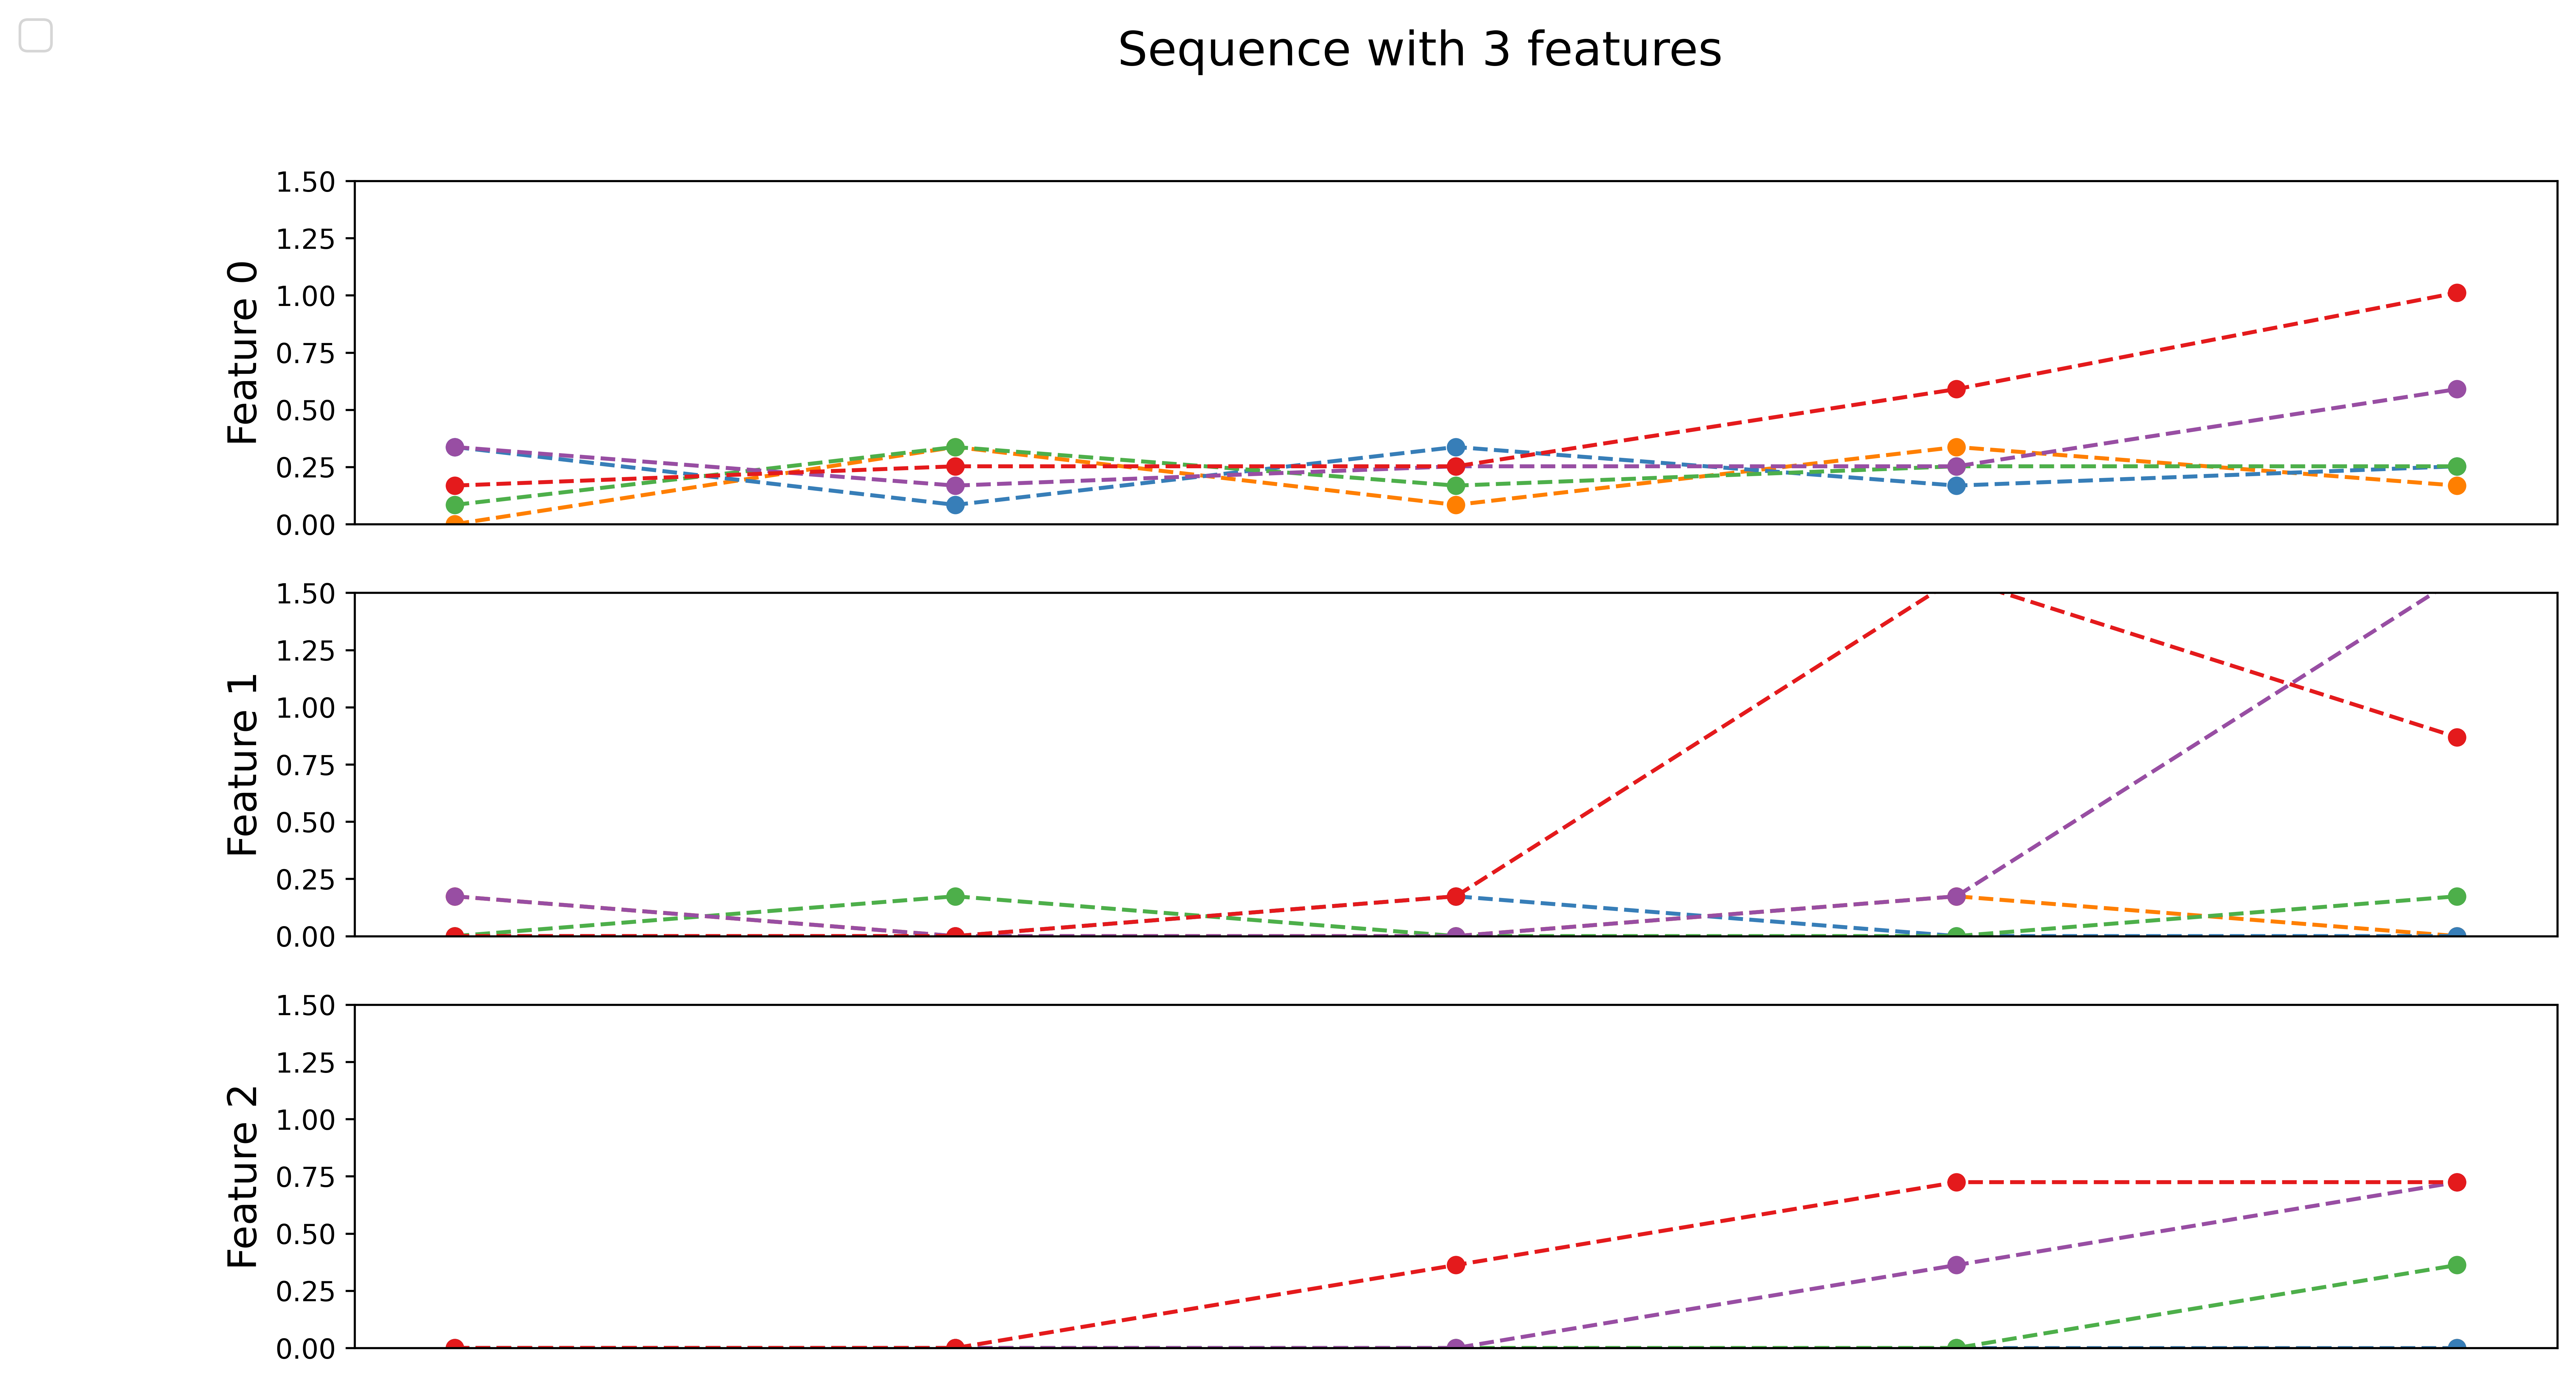

In [7]:
plot_sequences(test_x[46:51], scaled=True, features_names=[], labels=[], showFig=True, saveFig=False, outputDir="./test_single_phlist_test_set-out", figName="samples_46-51.png")

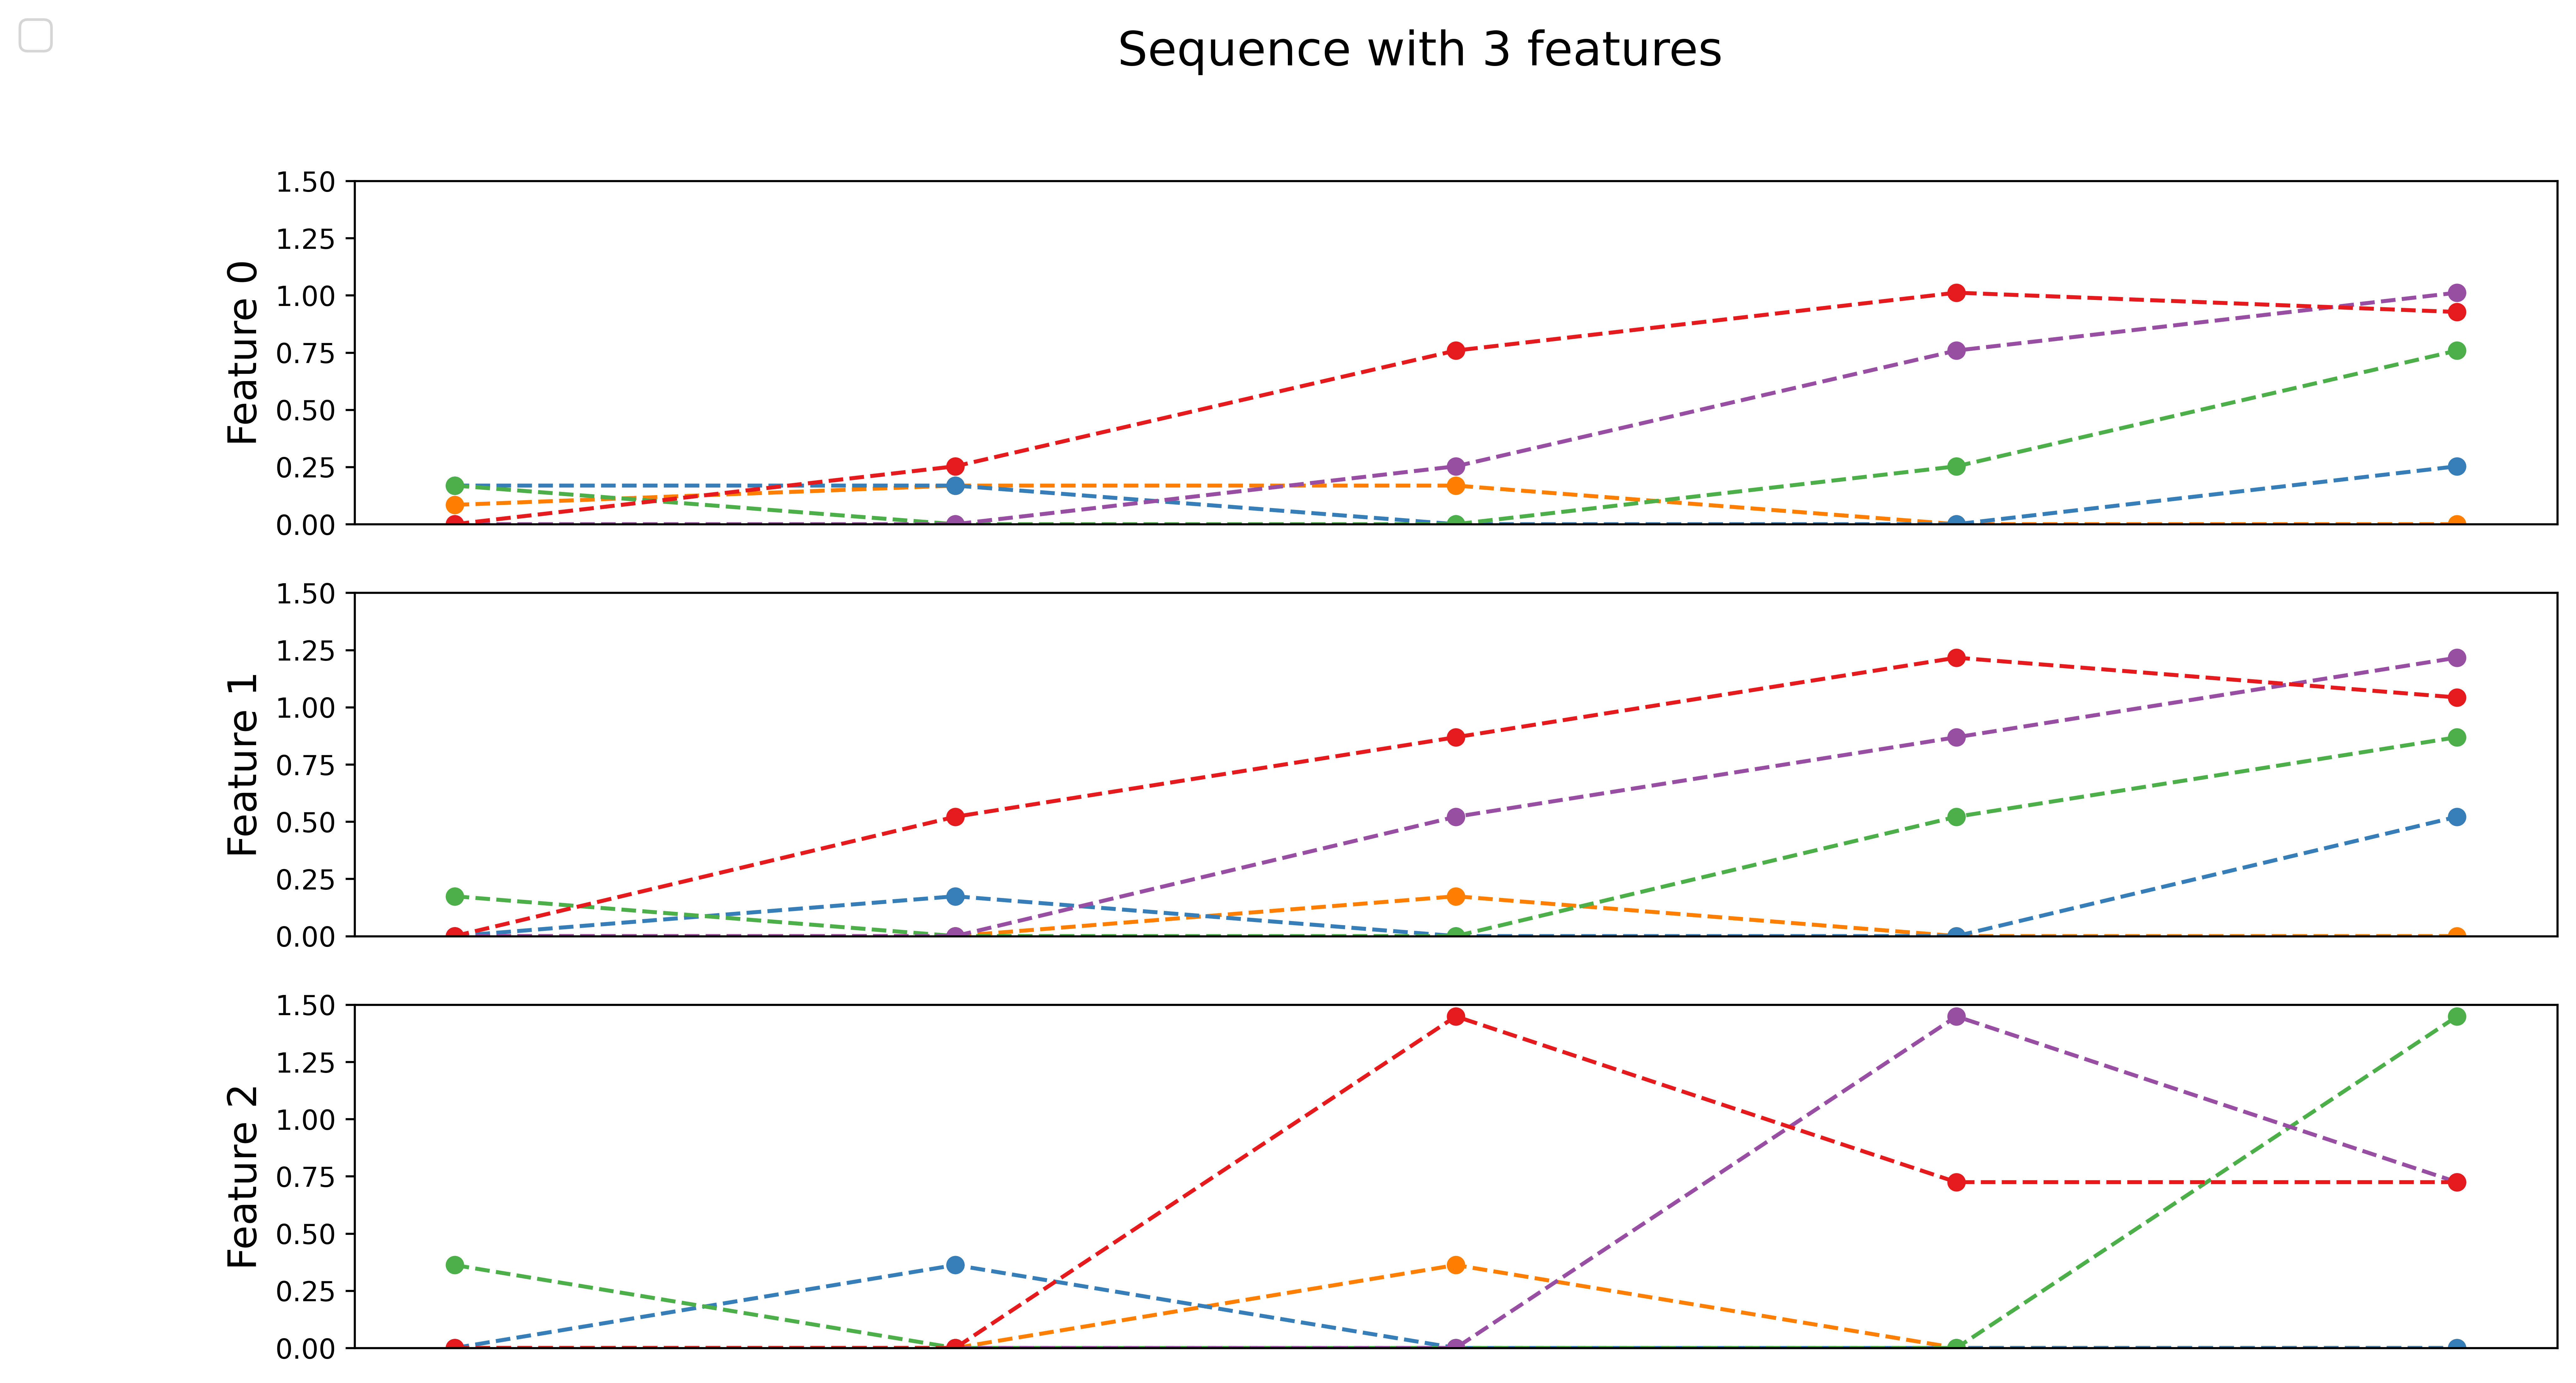

In [8]:
plot_sequences(test_x[143:148], scaled=True, features_names=[], labels=[], showFig=True, saveFig=False, outputDir="./test_single_phlist_test_set-out", figName="samples_137-142.png")

## Plot the original photon lists

In [26]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [9]:
original_pht_list = ds.dataset_params['test_path']

In [10]:
! plot_ap_timeseries -d $original_pht_list -o "./tmp"

Processing directory
Found 11 files in /data01/homes/baroncelli/phd/rtapipe/scripts/ml/dataset_generation/single_long_photon_list/testing
Processing: runid_run0406_ID000126_trial_0000000002_simtype_grb_onset_250_delay_0_offset_0.5_itype_te_itime_5_normalized_True.csv
Processing: runid_run0406_ID000126_trial_0000000004_simtype_grb_onset_250_delay_0_offset_0.5_itype_te_itime_5_normalized_True.csv
Processing: runid_run0406_ID000126_trial_0000000003_simtype_grb_onset_250_delay_0_offset_0.5_itype_te_itime_5_normalized_True.csv
Processing: runid_run0406_ID000126_trial_0000000005_simtype_grb_onset_250_delay_0_offset_0.5_itype_te_itime_5_normalized_True.csv
Processing: runid_run0406_ID000126_trial_0000000007_simtype_grb_onset_250_delay_0_offset_0.5_itype_te_itime_5_normalized_True.csv
Processing: runid_run0406_ID000126_trial_0000000006_simtype_grb_onset_250_delay_0_offset_0.5_itype_te_itime_5_normalized_True.csv
Processing: runid_run0406_ID000126_trial_0000000008_simtype_grb_onset_250_delay_0_

In [24]:
data = ! ls ./tmp
data = list(data)

0it [00:00, ?it/s]

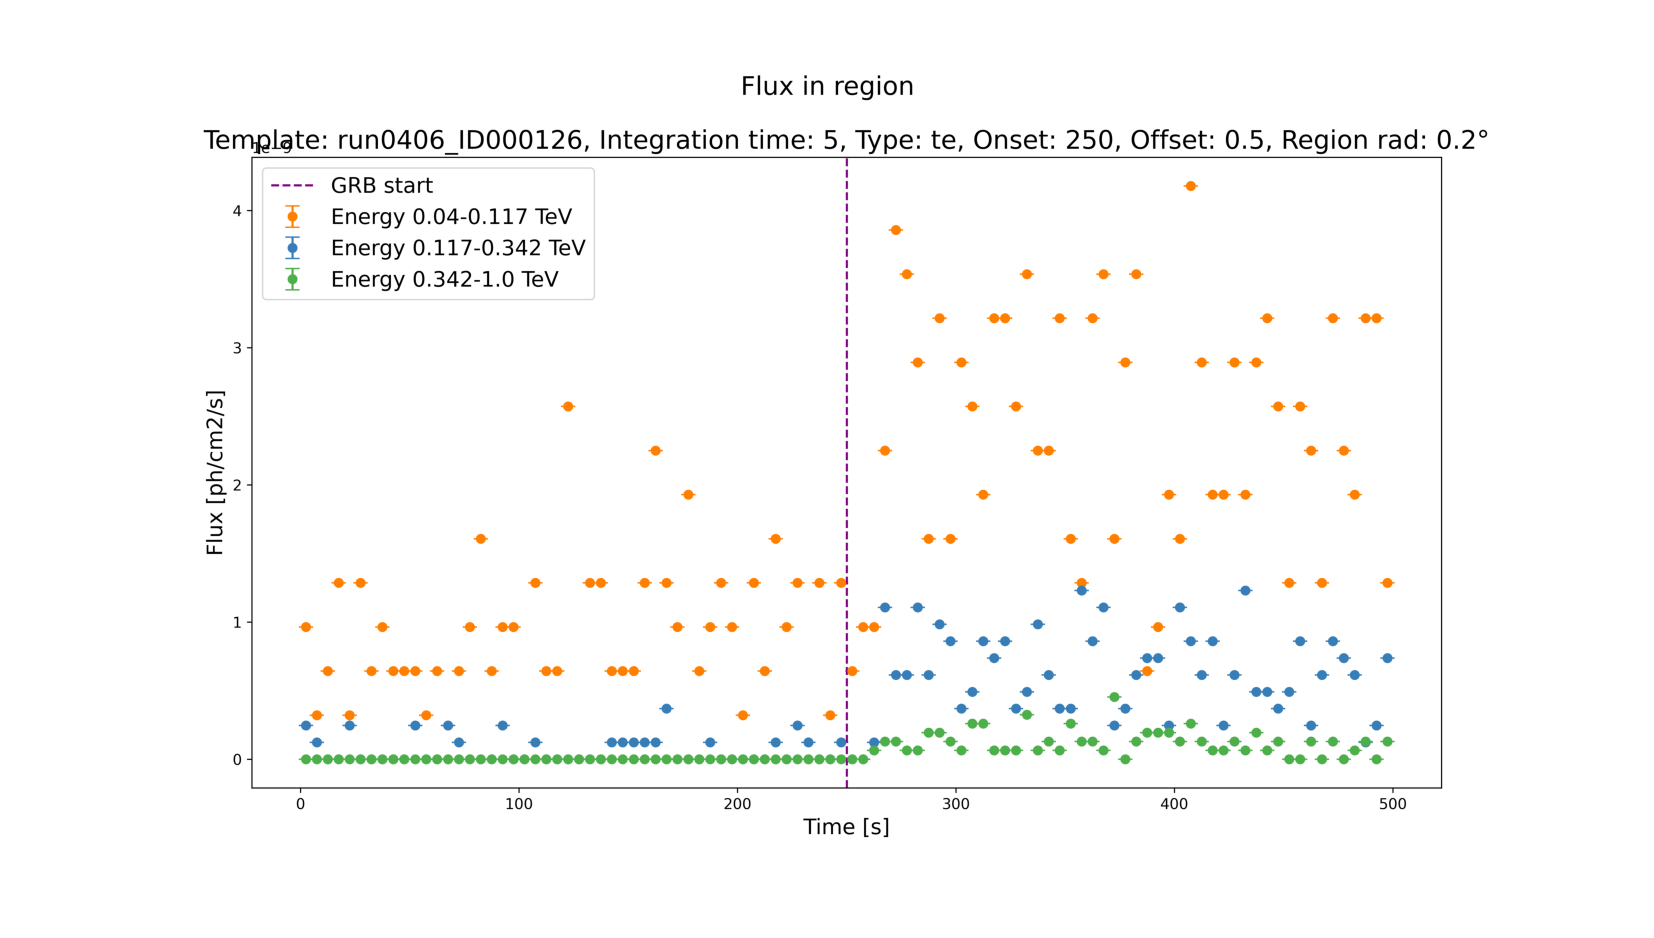

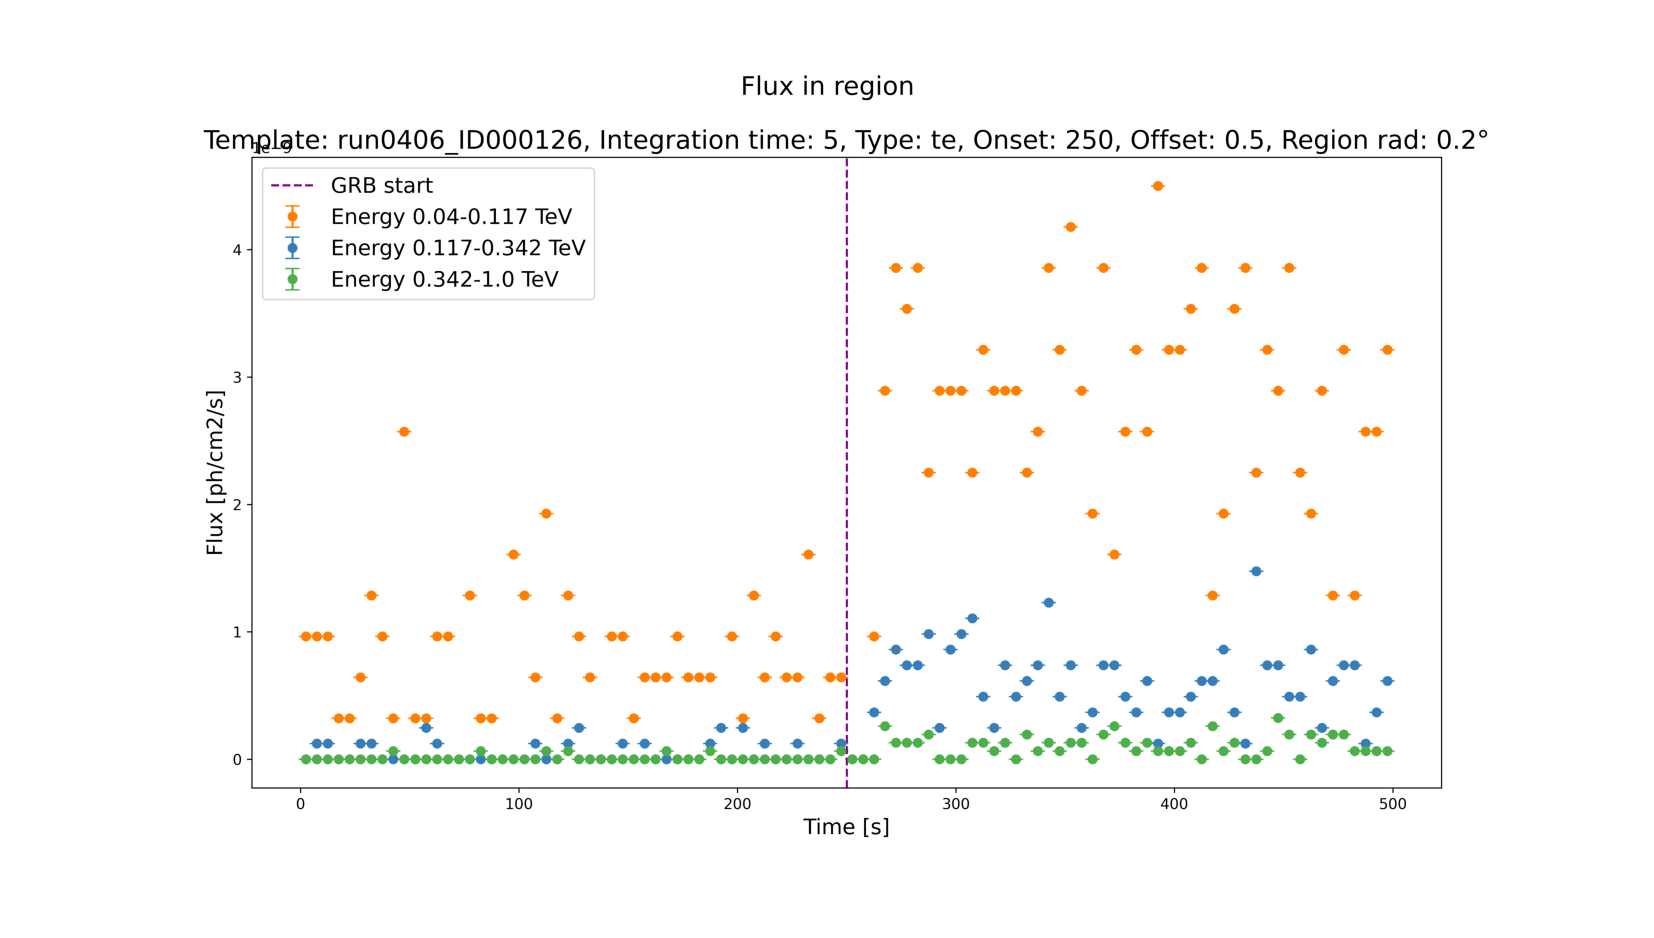

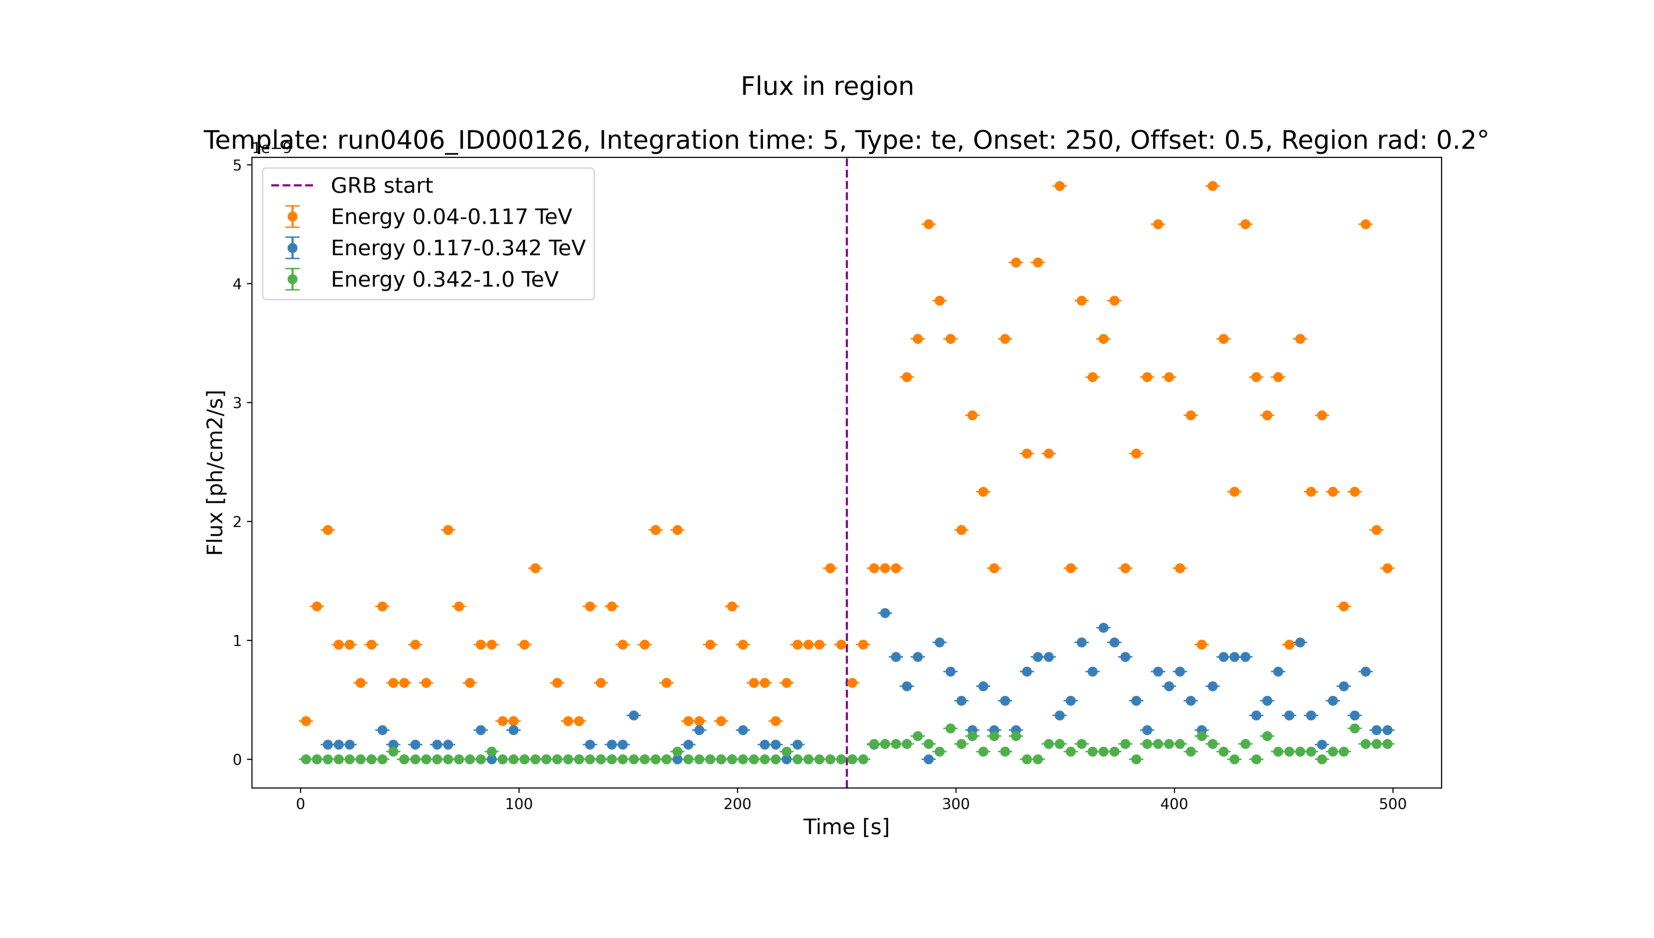

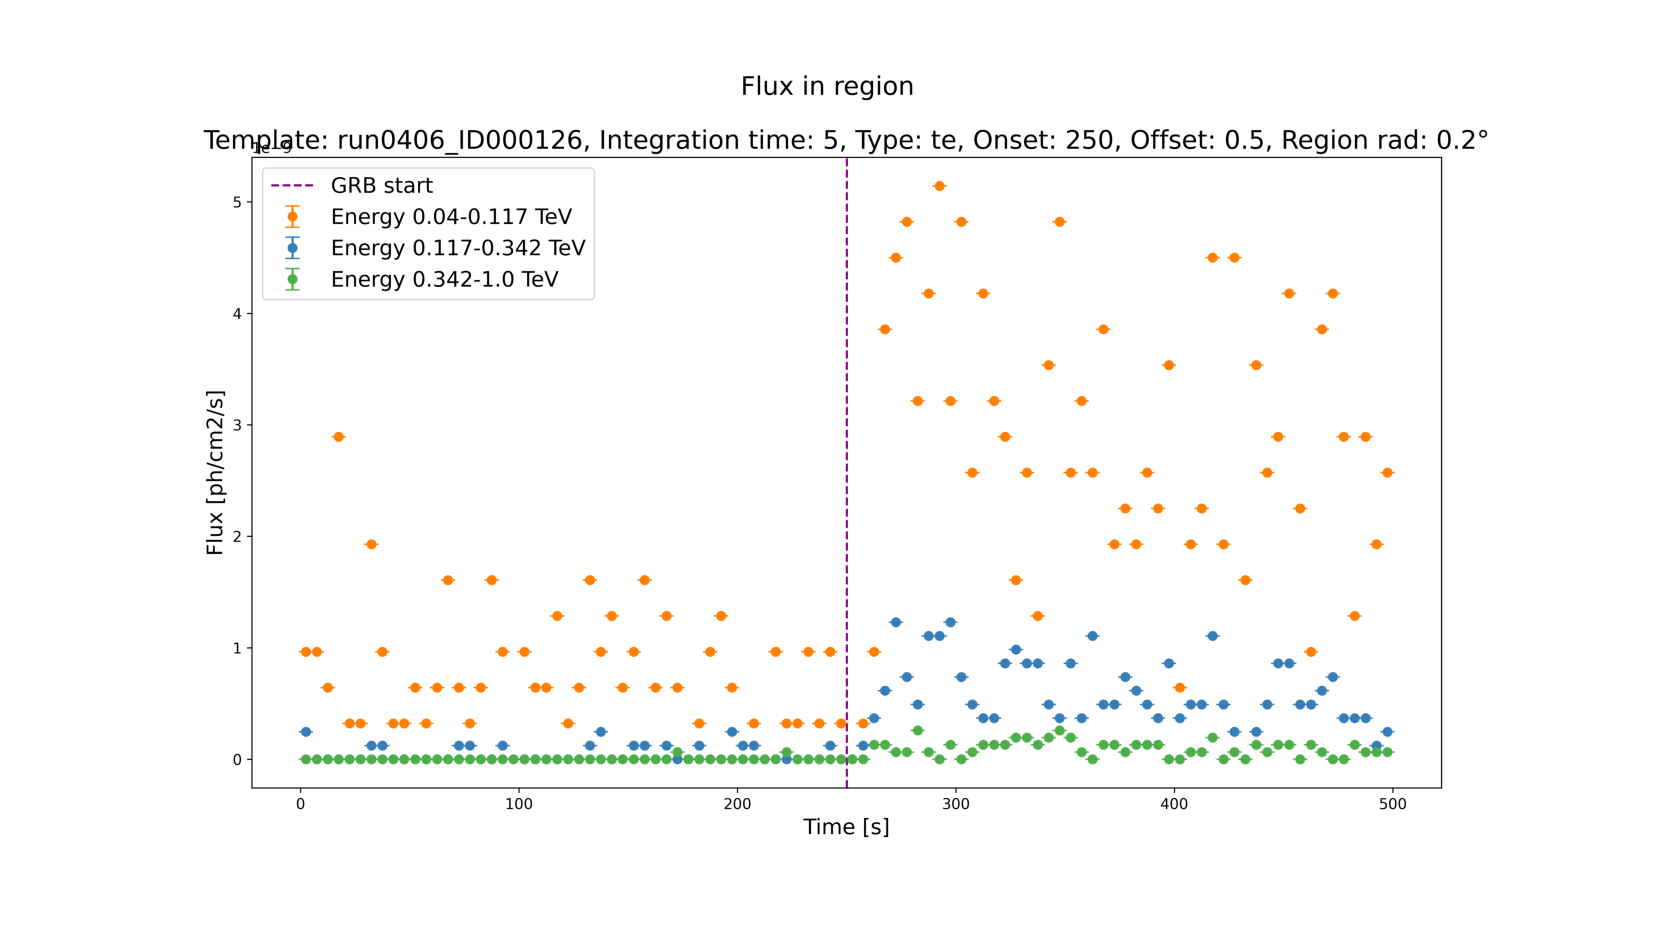

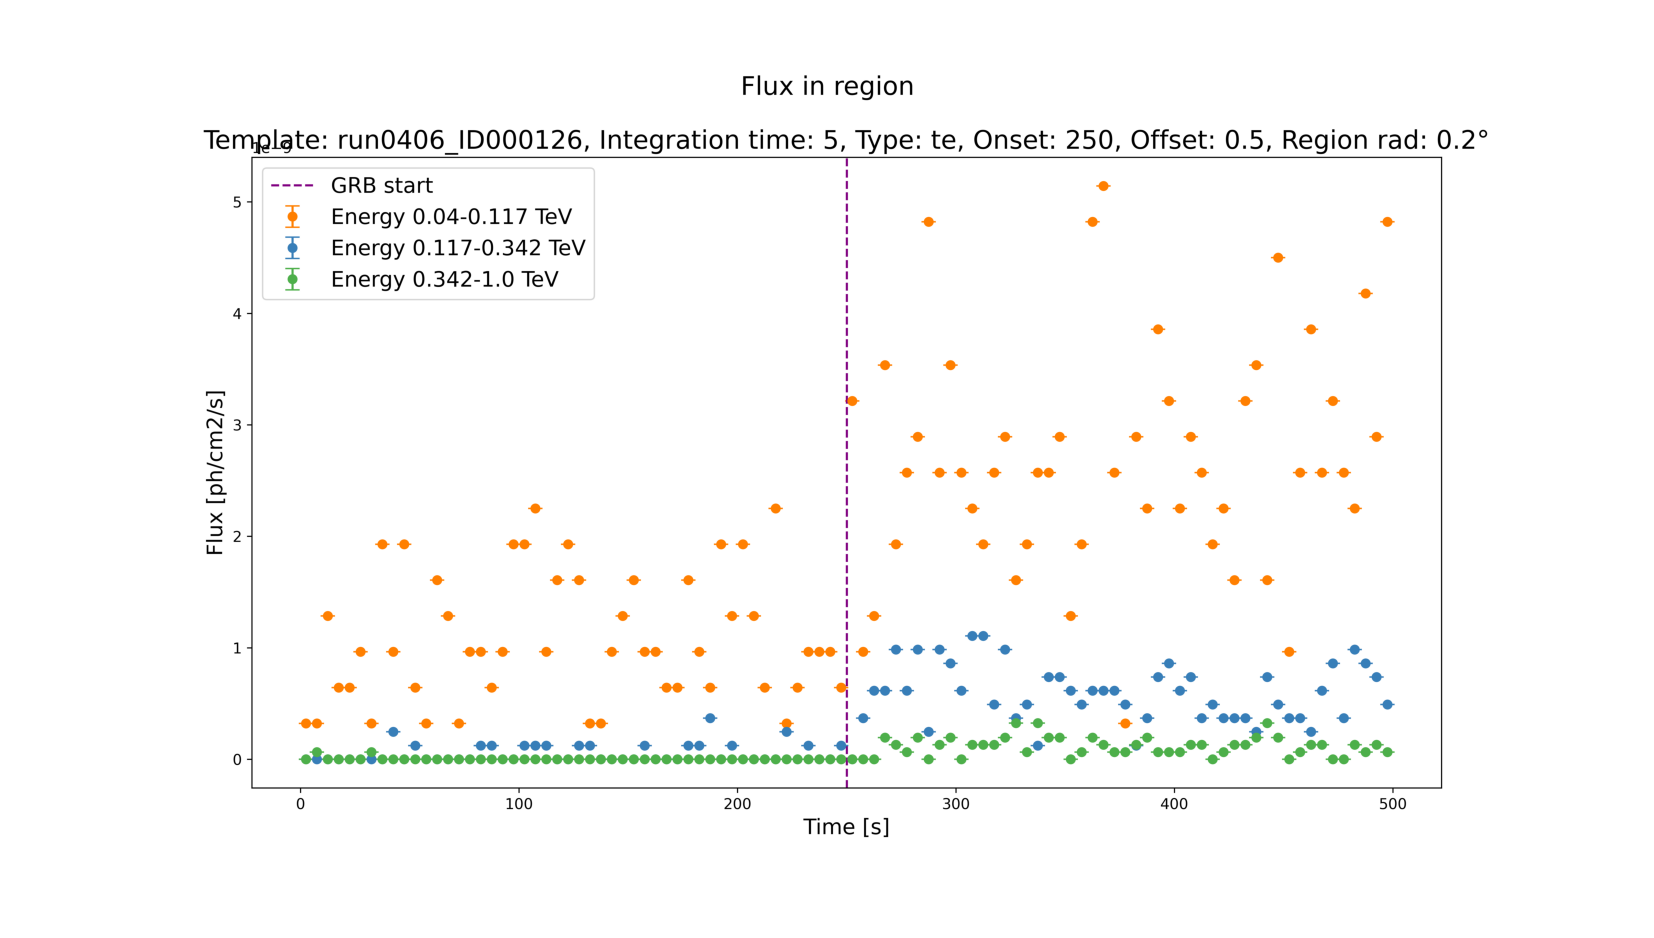

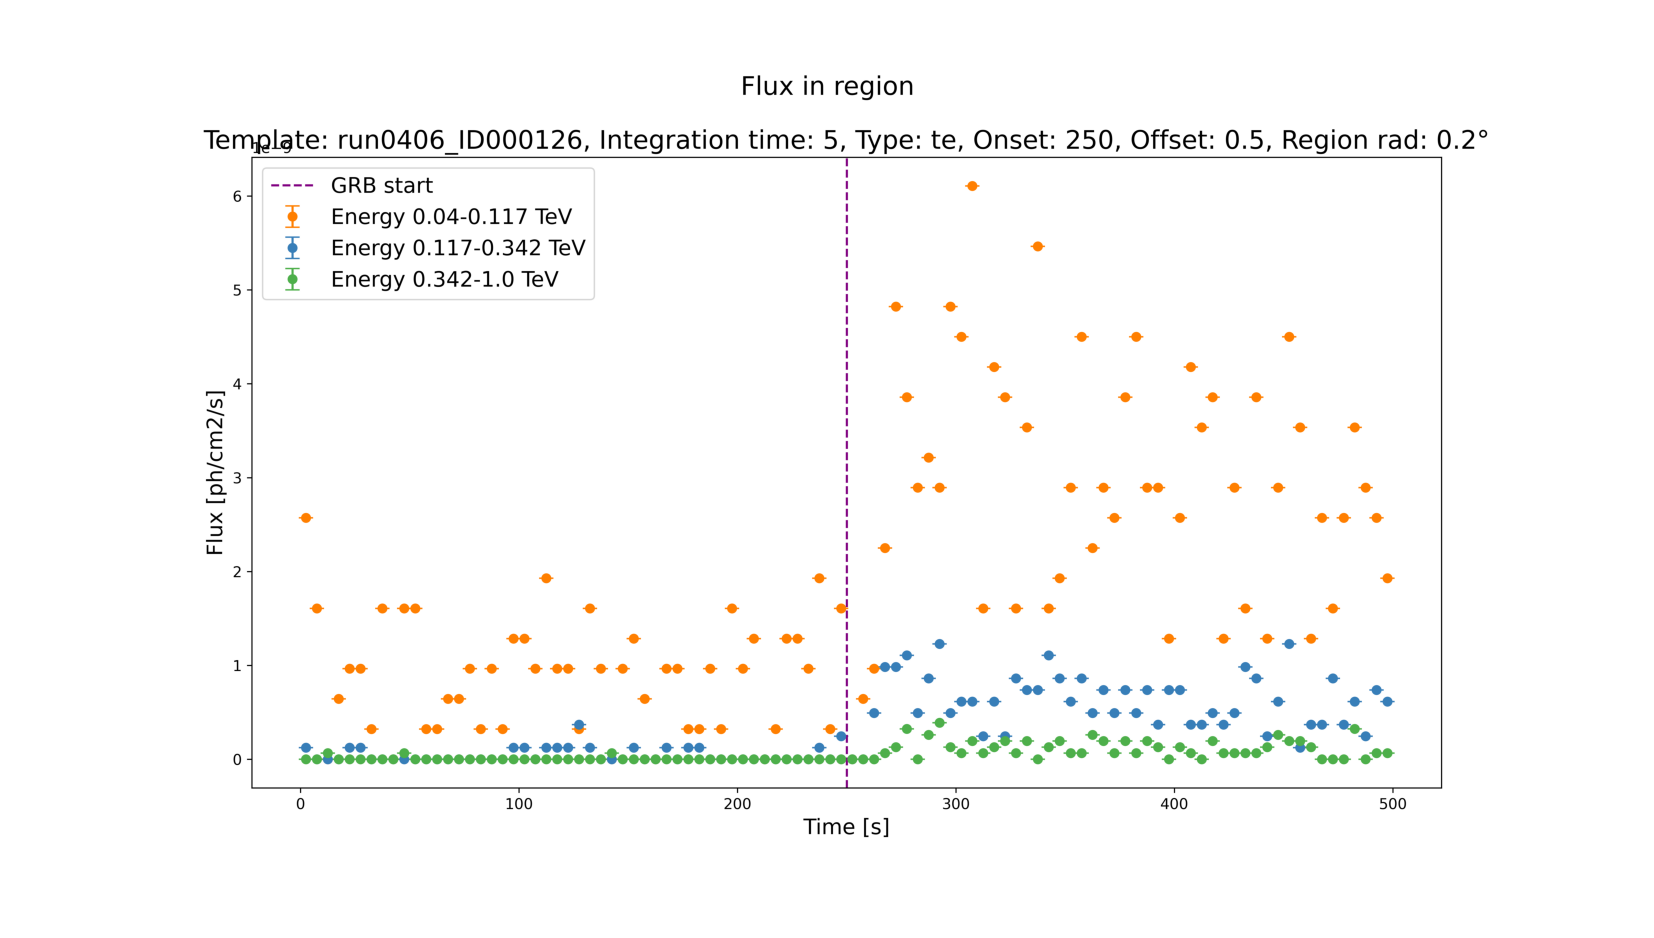

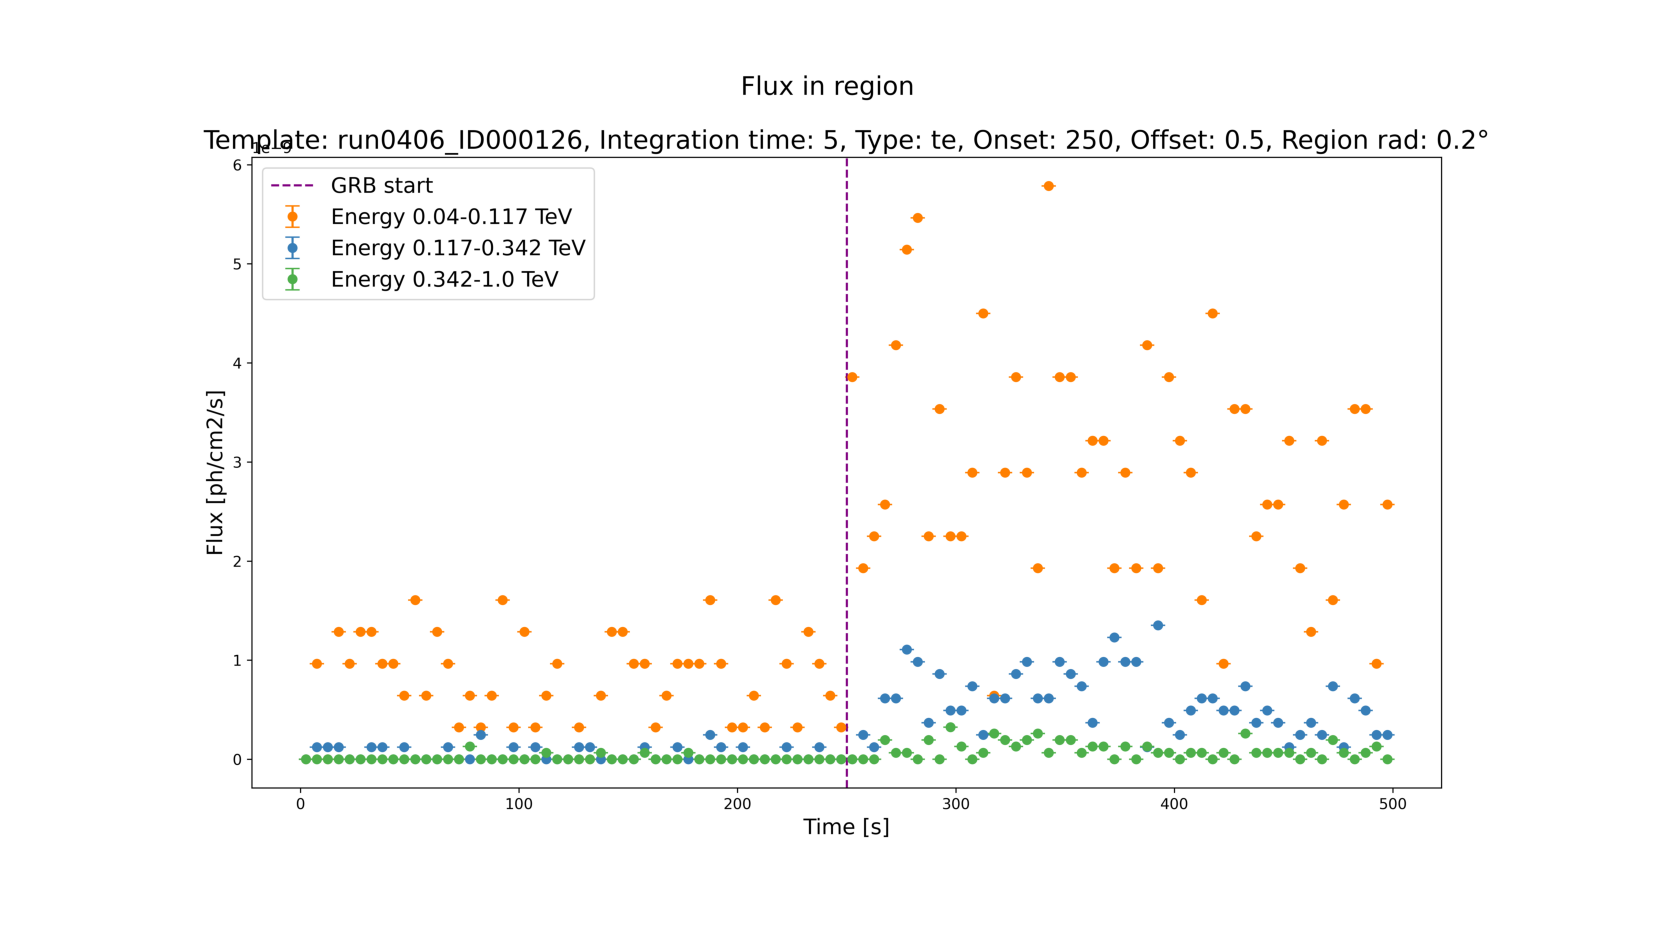

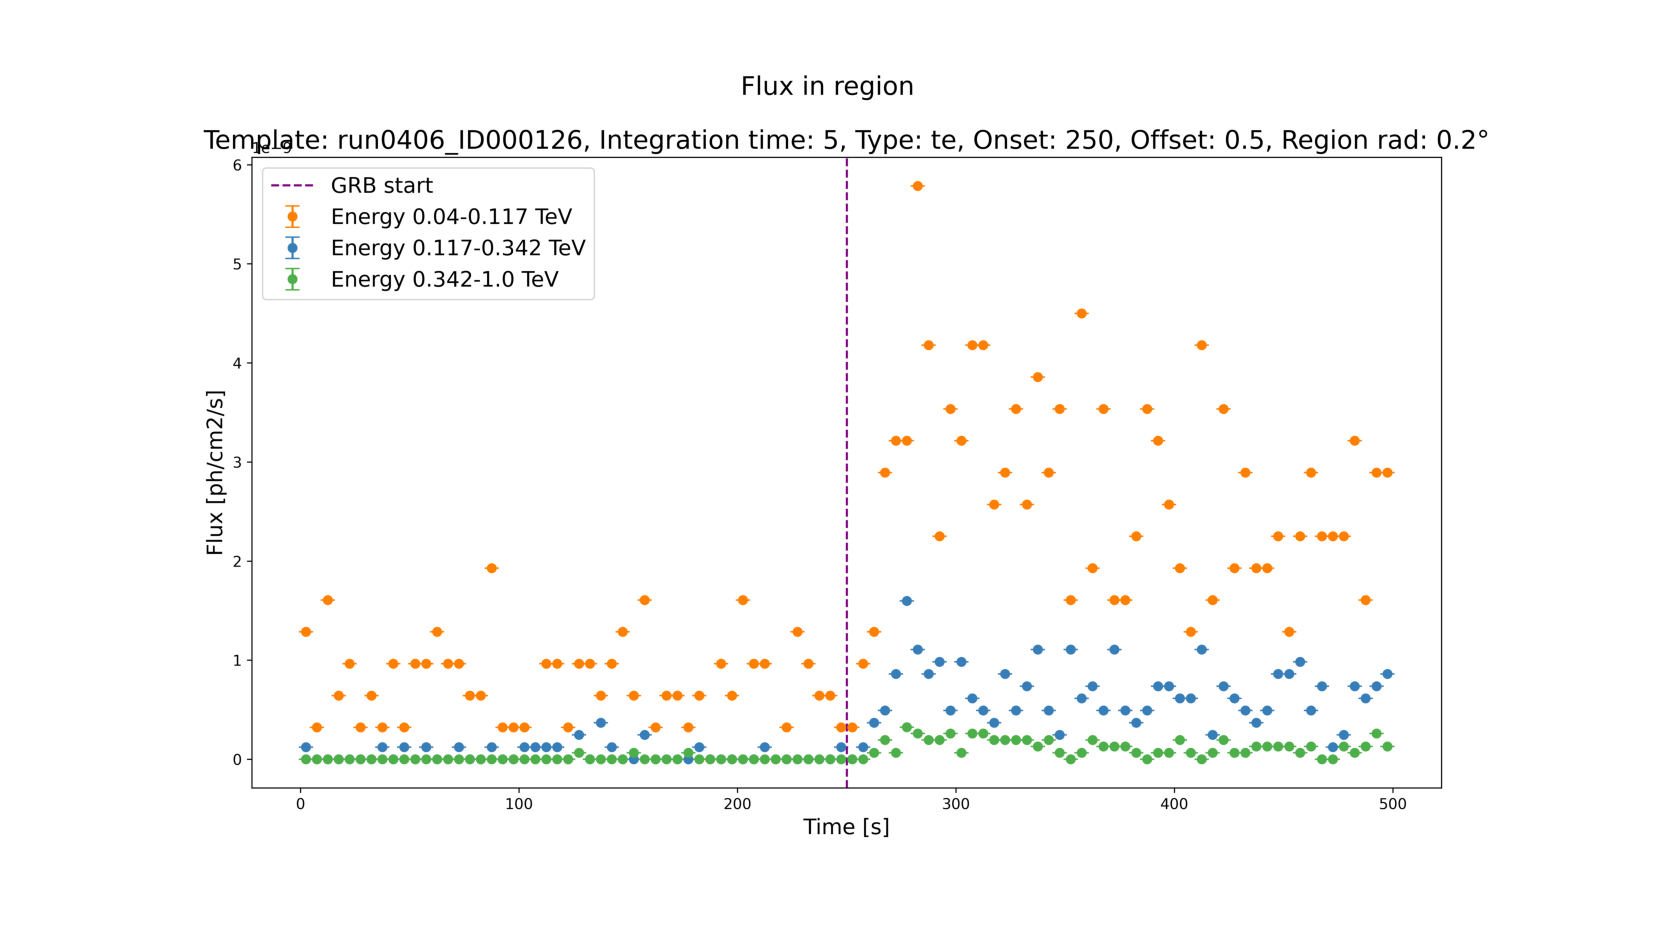

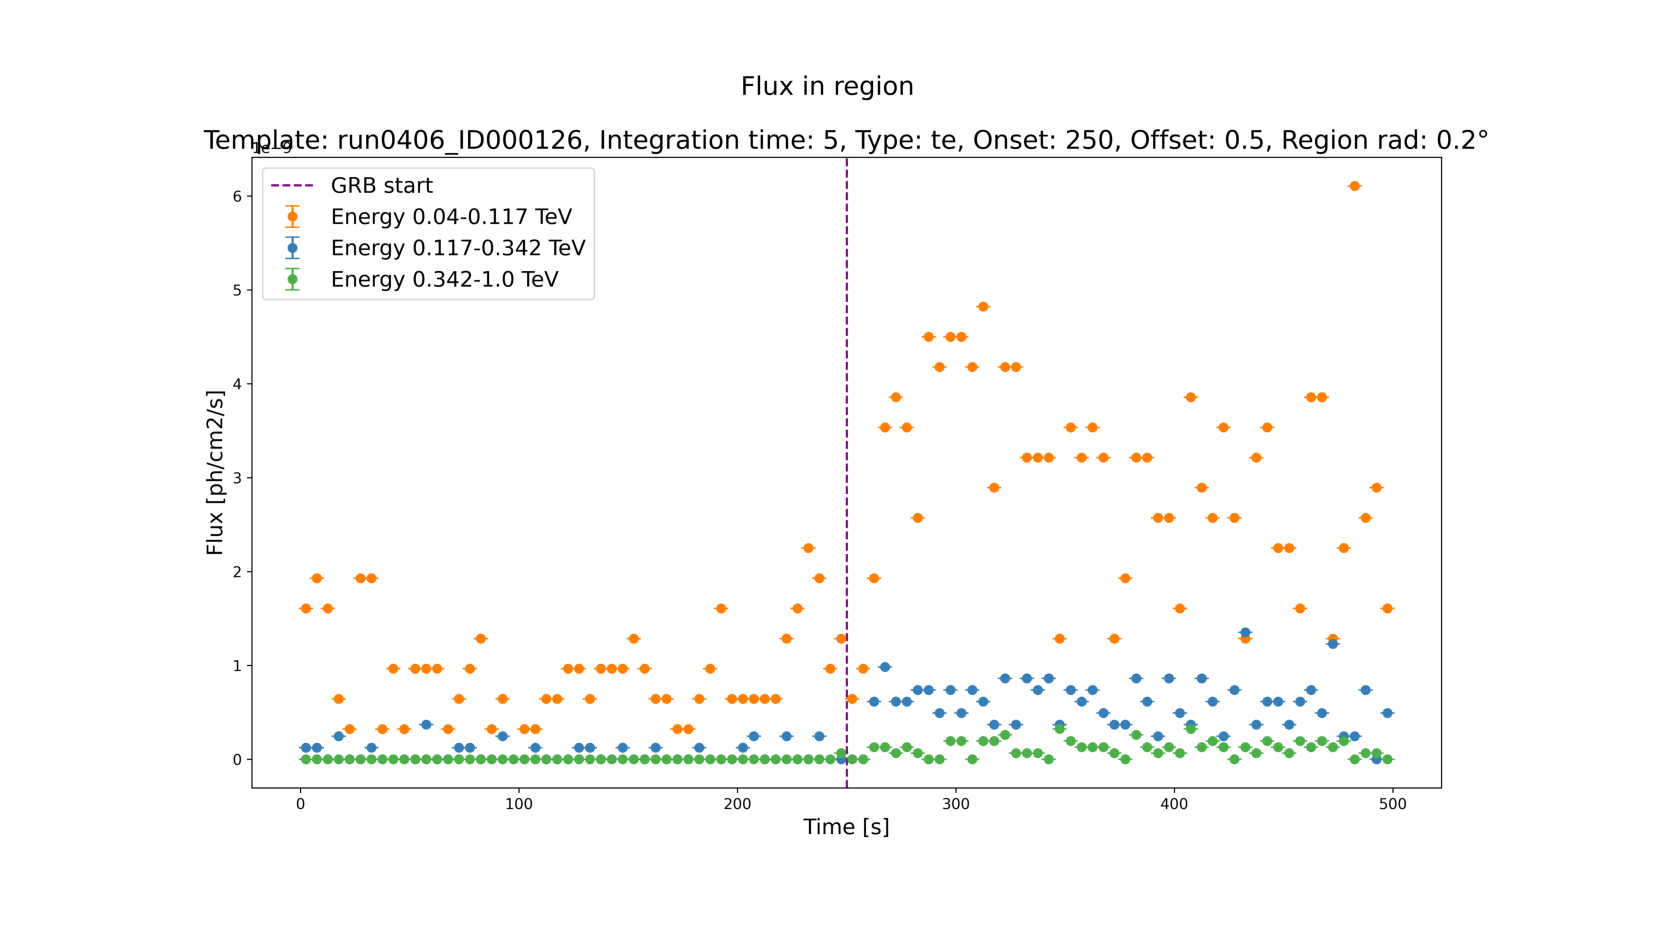

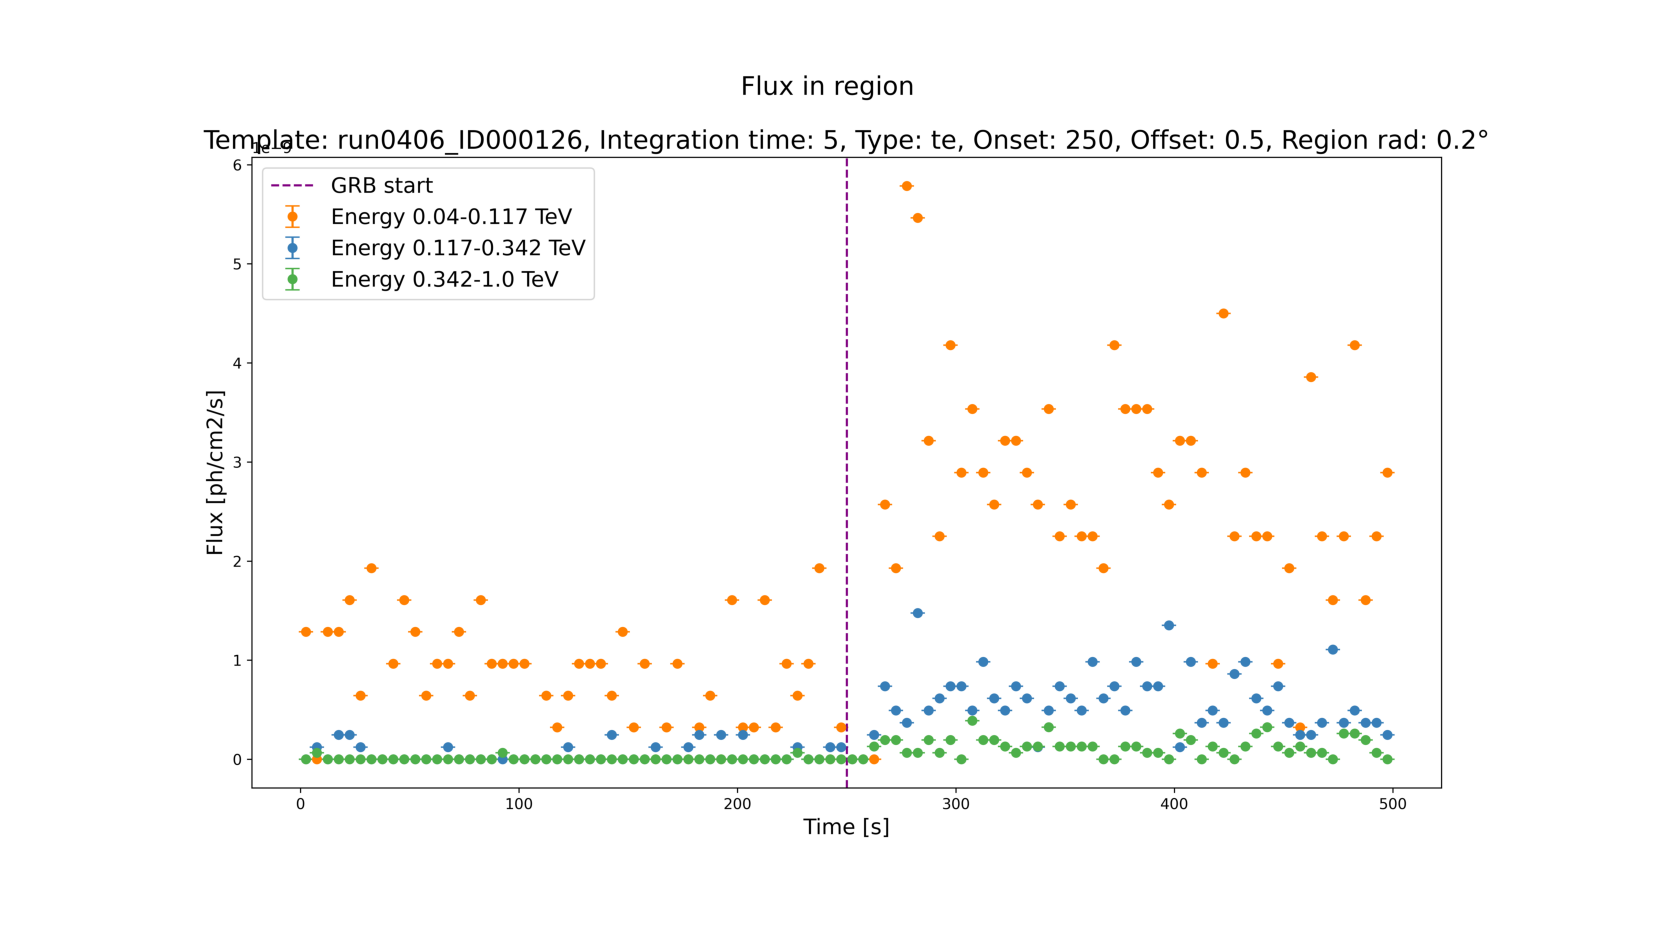

In [35]:
for i,f in tqdm(enumerate(data)):
    plt.imshow(mpimg.imread(f))
    plt.axis('off')
    plt.show()

# Evaluation metrics

## T = 5, TSL = 5, CNN and RNN models

In [37]:
configs = []

In [38]:
config = dotdict({})
config.timesteps = 5
config.nfeatures = 3
config.model_name = "AnomalyDetector_cnn_l2_u32"
config.model_dir = "/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221027-134533_T_5_TSL_5/model_AnomalyDetector_cnn_l2_u32_dataset_1201_tsl_5/epochs/epoch_117"
config.epoch = 117
configs.append(config)

In [39]:
config = dotdict({})
config.timesteps = 5
config.nfeatures = 3
config["model_name"] = "AnomalyDetector_rnn_l2_u32"
config["model_dir"] = "/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221027-134533_T_5_TSL_5/model_AnomalyDetector_rnn_l2_u32_dataset_1201_tsl_5/epochs/epoch_114"
config["epoch"] = 114
configs.append(config)

In [ ]:
for config in configs:
    print(f"\n\n************** Evaluating {config.model_name} **************")
    ad = AnomalyDetectorBuilder.getAnomalyDetector(name=config.model_name, timesteps=config.timesteps, nfeatures=config.nfeatures, load_model="True", training_epoch_dir=config.model_dir, training=False)
    metrics = ad.evaluate(test_x, test_y)
    for k,v in metrics.items():
        print(k,v)

## CNN predictions

In [ ]:
config = dotdict({})
config.timesteps = 5
config.nfeatures = 3
config.model_name = "AnomalyDetector_cnn_l2_u32"
config.model_dir = "/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221027-134533_T_5_TSL_5/model_AnomalyDetector_cnn_l2_u32_dataset_1201_tsl_5/epochs/epoch_117"
config.epoch = 117
configs.append(config)

In [ ]:
ad = AnomalyDetectorBuilder.getAnomalyDetector(name=config.model_name, timesteps=config.timesteps, nfeatures=config.nfeatures, load_model="True", training_epoch_dir=config.model_dir, training=False)

In [ ]:
ad.plot_predictions(test_x, test_y, max_plots=999, features_names=features_names, epoch=config.epoch, figName=f"{config.model_name}_predictions_multi_trials_dataset.png")

## RNN predictions

In [40]:
config = dotdict({})
config.timesteps = 5
config.nfeatures = 3
config.model_name = "AnomalyDetector_rnn_l2_u32"
config.model_dir = "/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221027-134533_T_5_TSL_5/model_AnomalyDetector_rnn_l2_u32_dataset_1201_tsl_5/epochs/epoch_114"
config.epoch = 114

In [41]:
ad = AnomalyDetectorBuilder.getAnomalyDetector(name=config.model_name, timesteps=config.timesteps, nfeatures=config.nfeatures, load_model="True", training_epoch_dir=config.model_dir, training=False)

AnomalyDetector_rnn_l2_u32 - input shape: (5,3)


In [ ]:
ad.plot_predictions(test_x, test_y, max_plots=999, features_names=features_names, epoch=config.epoch, figName=f"{config.model_name}_predictions_multi_trials_dataset.png")